Zadanie:

 Przeprowadziliśmy ankietę mającą zbadać cechy psychologiczne polskich internautów. Na wynik badania składają się dwa pliki:

1. users.csv - dane demograficzne ankietowanych oraz przeglądarka z jakiej korzystają.

2. personality.csv - profil psychologiczny ankietowanych, opisany przez 5 cech: A-E.

 
Opis cech demograficznych:

·       D01 Płeć

·       D02 Rok urodzenia

·       D03 Wykształcenie - podstawowe, zawodowe, średnie, wyższe

·       D04 Status zawodowy

·       D05 Wielkość miejscowości - wieś, do 20k, do 100k, do 500k, powyżej

·       D06 Sytuacja finansowa

·       D07 Rozmiar gospodarstwa domowego

 
Szukamy odpowiedzi na następujące pytania:

1. Czy istnieje związek pomiędzy posiadanymi przez nas informacjami o ankietowanych, a ich profilem psychologicznym?

2. Czy możemy podzielić ankietowanych na grupy osób o podobnym profilu psychologicznym? Jakie to grupy, co wyróżnia każdą z nich, jaka jest ich charakterystyka demograficzna?

 
Przeprowadź odpowiednią analizę danych. Przygotuj krótkie, wysokopoziomowe podsumowanie managementu oraz paczkę z kodem pozwalającym na odtworzenie najważniejszych wyników oraz dalszy rozwój rozwiązań 

## Exploratory Data Analysis

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import eda

In [3]:
users_df = pd.read_csv('data/users.csv')
personality_df = pd.read_csv('data/personality.csv')

In [4]:
users_df.head()

,UserIdentifier,UserBrowser,D01,D02,D03,D04,D05,D06,D07
0,d2d10f362bb1d0092174a660778cbe50,Firefox 69.0 (Desktop),M,1954.0,3.0,4.0,2.0,6.0,2.0
1,083a56a91d0d1ee4e66643849133b2b3,Chrome 70.0.3538.110 (Mobile),M,1963.0,2.0,2.0,2.0,7.0,2.0
2,fdc1004b329f2aca4c81ad59c93c1be0,Chrome 77.0.3865.90 (Desktop),K,1975.0,4.0,1.0,4.0,5.0,6.0
3,8b8a4372a0f3fd3e1a1d4c531211506e,Chrome 75.0.3770.142 (Desktop),K,1991.0,3.0,2.0,4.0,5.0,4.0
4,58d0c701bf73a5949e2ee29f387fb5a2,Chrome 78.0.3904.108 (Mobile),M,2000.0,3.0,3.0,1.0,7.0,6.0


In [5]:
personality_df.head()

,UserIdentifier,A,B,C,D,E
0,d2d10f362bb1d0092174a660778cbe50,0.041197,-0.389188,-0.257404,0.732678,-0.769127
1,083a56a91d0d1ee4e66643849133b2b3,-0.596461,0.620304,-0.611045,-0.256928,-0.244441
2,fdc1004b329f2aca4c81ad59c93c1be0,-1.198166,-0.821102,0.298394,-0.031738,0.821793
3,8b8a4372a0f3fd3e1a1d4c531211506e,-0.344910,-1.611630,0.220709,-0.323851,-0.127276
4,58d0c701bf73a5949e2ee29f387fb5a2,-0.365047,1.094319,-0.187957,-0.254589,0.554409


In [6]:
print('"Users" Dataframe')
print('Number of samples per column: \n'+"-"*20+"\n", 
      users_df.count())

"Users" Dataframe
Number of samples per column: 
--------------------
 UserIdentifier    1868
UserBrowser       1868
D01               1868
D02               1868
D03               1868
D04               1868
D05               1867
D06               1867
D07               1867
dtype: int64


In [7]:
print('"Personality" Dataframe')
print('Number of samples per column: \n'+"-"*20+"\n", 
      personality_df.count())

"Personality" Dataframe
Number of samples per column: 
--------------------
 UserIdentifier    1681
A                 1677
B                 1671
C                 1668
D                 1676
E                 1676
dtype: int64


--------------------------------------------------
## Dataframe **Users** - the Box and Density plots of numerical features 

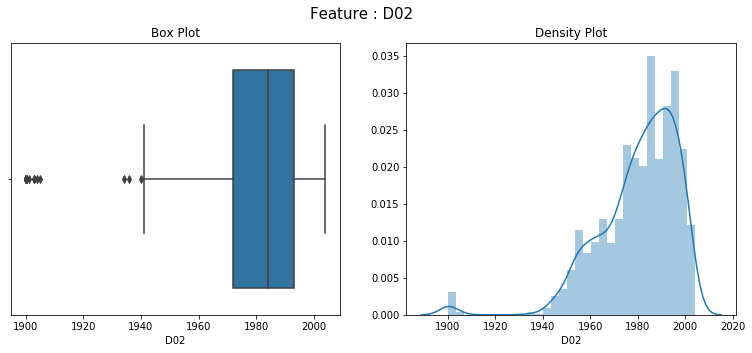

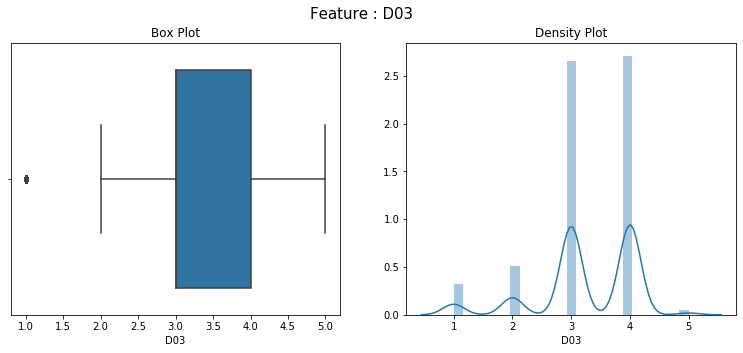

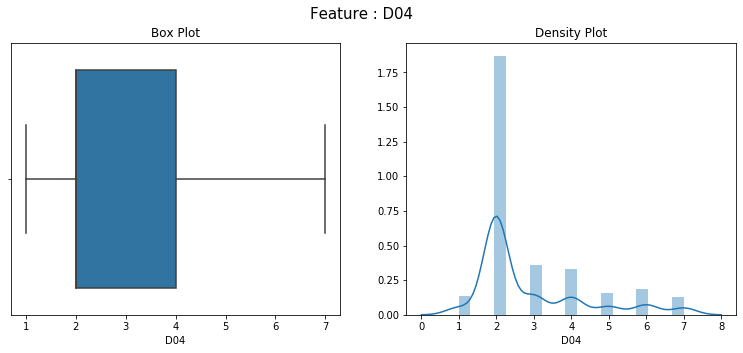

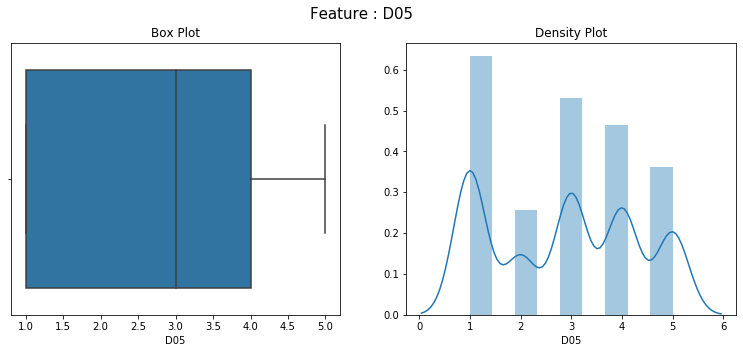

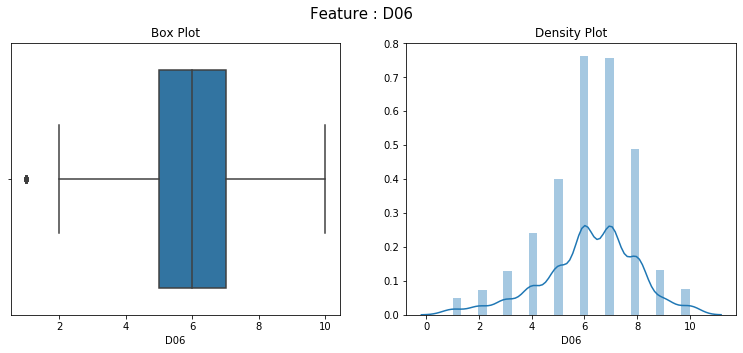

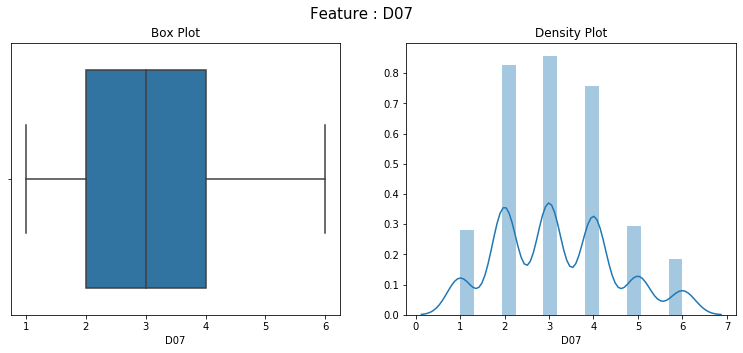

In [8]:
path = 'figures/basic_plots'
users_num = users_df.select_dtypes(exclude='object').columns
for col in users_num:
    eda.basic_summary_plots(users_df[col], path, save=False)

## Dataframe **Users** - the Frequency plots of categorical features

/Users/ostyk/Desktop/recovery_github/AdEmotion/eda.py:38: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  data_col.value_counts().plot('bar')


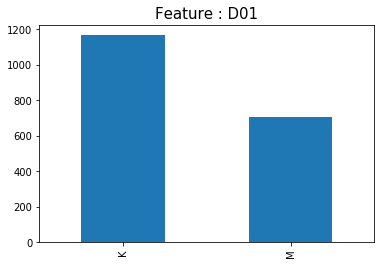

In [9]:
eda.categ_summary(users_df['D01'])

TODO: find a way to present the "version" column

---------------------------
## Dataframe **Personality** 

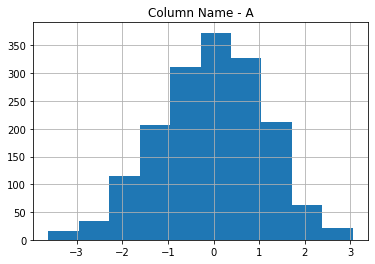

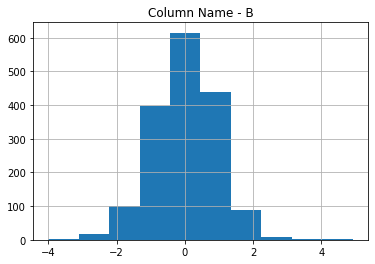

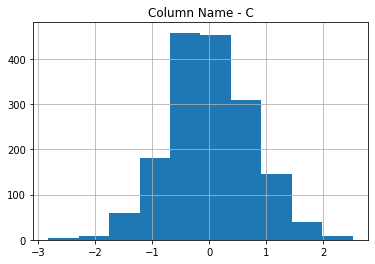

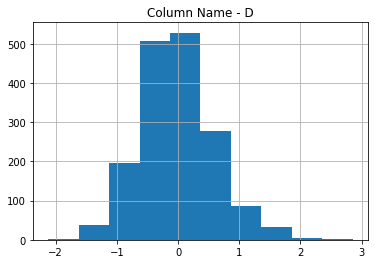

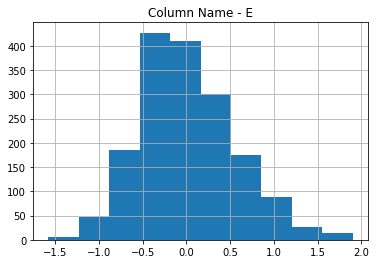

In [10]:
for col in personality_df.columns[1:]:
    personality_df[col].hist()
    plt.title("Column Name - " + col)
    plt.show()

# Data cleaning
1. 'UserBrowser' -> ['browser', 'version', 'device']
2. 'D01' (sex) -> maybe into 0/1 ?
3. ['D02', 'D03', 'D04', 'D05', 'D06', 'D07'] -> dtype = int16
4. 'D02' (year) -> 5-years groups? and/or 10-years groups?
5. ['D05', 'D06', 'D07'] -> try to fill nan ?

### 1. Split 'UserBrowser' into many columns: 'Browser', 'Version', 'Device'

In [11]:
users_df[['Browser', 'Version', 'Device']] = users_df.UserBrowser.apply(lambda row: pd.Series(row.split(" ")))
users_df.Device = users_df.Device.apply(lambda row: row.strip('()'))
users_df.drop('UserBrowser', axis=1, inplace=True)
users_df.head()

,UserIdentifier,D01,D02,D03,D04,D05,D06,D07,Browser,Version,Device
0,d2d10f362bb1d0092174a660778cbe50,M,1954.0,3.0,4.0,2.0,6.0,2.0,Firefox,69.0,Desktop
1,083a56a91d0d1ee4e66643849133b2b3,M,1963.0,2.0,2.0,2.0,7.0,2.0,Chrome,70.0.3538.110,Mobile
2,fdc1004b329f2aca4c81ad59c93c1be0,K,1975.0,4.0,1.0,4.0,5.0,6.0,Chrome,77.0.3865.90,Desktop
3,8b8a4372a0f3fd3e1a1d4c531211506e,K,1991.0,3.0,2.0,4.0,5.0,4.0,Chrome,75.0.3770.142,Desktop
4,58d0c701bf73a5949e2ee29f387fb5a2,M,2000.0,3.0,3.0,1.0,7.0,6.0,Chrome,78.0.3904.108,Mobile


### 2 . sex into binary

In [12]:
users_df['Sex'] = users_df['D01'].map({"M":0, "K": 1})

### 3. Change dtypes from 'float64' to 'int16'
(Columns D05-D07 have 'nan' values, hence they are left as float)

In [13]:
users_df.dtypes

UserIdentifier     object
D01                object
D02               float64
D03               float64
D04               float64
D05               float64
D06               float64
D07               float64
Browser            object
Version            object
Device             object
Sex                 int64
dtype: object

In [14]:
users_df = users_df.astype(dtype={'D02':np.int16, 'D03':np.int16, 'D04':np.int16})

#### check for those nan values

In [15]:
col_nan = users_df.isna().sum()
print("Column | %")
col_nan[col_nan > 0.]

Column | %


D05    1
D06    1
D07    1
dtype: int64

In [16]:
users_df[users_df['D05'].isna()]

,UserIdentifier,D01,D02,D03,D04,D05,D06,D07,Browser,Version,Device,Sex
557,afe841be2dababac5a440e0c14a9f903,K,1981,4,2,NaN,NaN,NaN,Chrome,78.0.3904.108,Mobile,1


only one record with unknown information, for simplicity reasons we discard it. However, if the data is scarce it should be filled with i.e. averages ofother columns if applicable

In [17]:
users_df = users_df.dropna()

### 4. Assuming that this data comes from the Polish market, we can divide the year of birth column into generations
source : https://natemat.pl/235903,do-jakiego-pokolenia-naleze-generacja-z-to-najliczniejsza-grupa-w-polsce

![docs/pokolenia.jpg](docs/pokolenia.jpg)

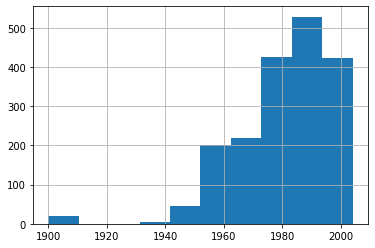

In [18]:
users_df['D02'].hist()

In [19]:
year_of_birth_mapper = {"pokolenie Z": range(1995, 2020),
                       "pokolenie Y": range(1980, 1995),
                       "pokolenie X": range(1964, 1980),
                       "pokolenie BB": range(1946, 1964),
                       "other": range(users_df['D02'].min(), 1946)}

In [20]:
users_df['Generation'] = users_df['D02'].apply(lambda x: next((k for k, v in year_of_birth_mapper.items() if x in v), 0))

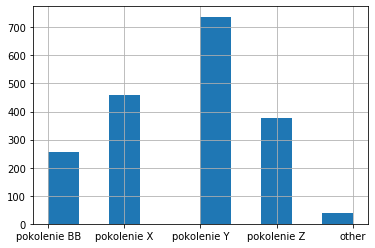

In [21]:
users_df['Generation'].hist()

In [22]:
users_df = users_df.rename(columns = {"D03": "Education", 
                                      "D05": "City size", 
                                      "D04": "Professional status", 
                                     "D06": "Financial_situation",
                                     "D07": "Size of Household"})

In [23]:
users_df = users_df.drop(["D01", "D02"], axis=1)

#### We can assume that the higher the number, the better the financial situation. Also this follows a normal distribution implying the wealth distribution is fairly representative of the population.

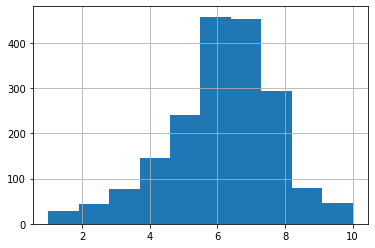

In [24]:
users_df['Financial_situation'].hist()

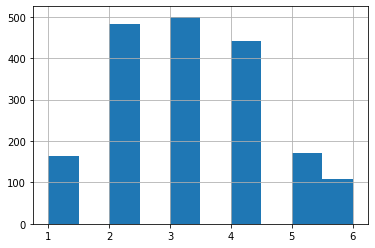

In [25]:
users_df['Size of Household'].hist()

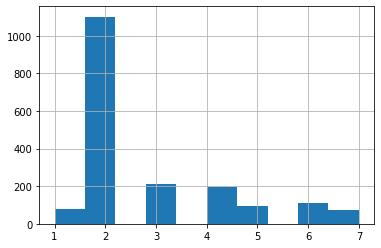

In [26]:
users_df['Professional status'].hist()

In [27]:
users_df.head()

,UserIdentifier,Education,Professional status,City size,Financial_situation,Size of Household,Browser,Version,Device,Sex,Generation
0,d2d10f362bb1d0092174a660778cbe50,3,4,2.0,6.0,2.0,Firefox,69.0,Desktop,0,pokolenie BB
1,083a56a91d0d1ee4e66643849133b2b3,2,2,2.0,7.0,2.0,Chrome,70.0.3538.110,Mobile,0,pokolenie BB
2,fdc1004b329f2aca4c81ad59c93c1be0,4,1,4.0,5.0,6.0,Chrome,77.0.3865.90,Desktop,1,pokolenie X
3,8b8a4372a0f3fd3e1a1d4c531211506e,3,2,4.0,5.0,4.0,Chrome,75.0.3770.142,Desktop,1,pokolenie Y
4,58d0c701bf73a5949e2ee29f387fb5a2,3,3,1.0,7.0,6.0,Chrome,78.0.3904.108,Mobile,0,pokolenie Z


#### end of column preprocessing

# column exploration

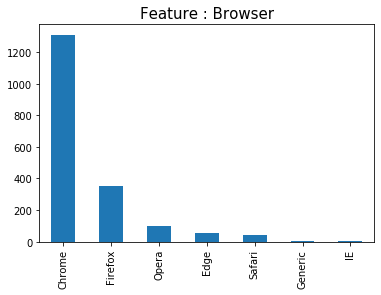

In [28]:
eda.categ_summary(users_df['Browser'])

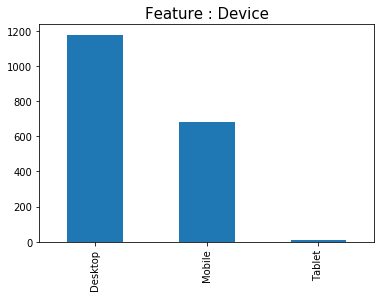

In [29]:
eda.categ_summary(users_df['Device'])

# Psychological data analysis

### pair plot for personnality data

In [101]:
personality_df = personality_df.dropna()

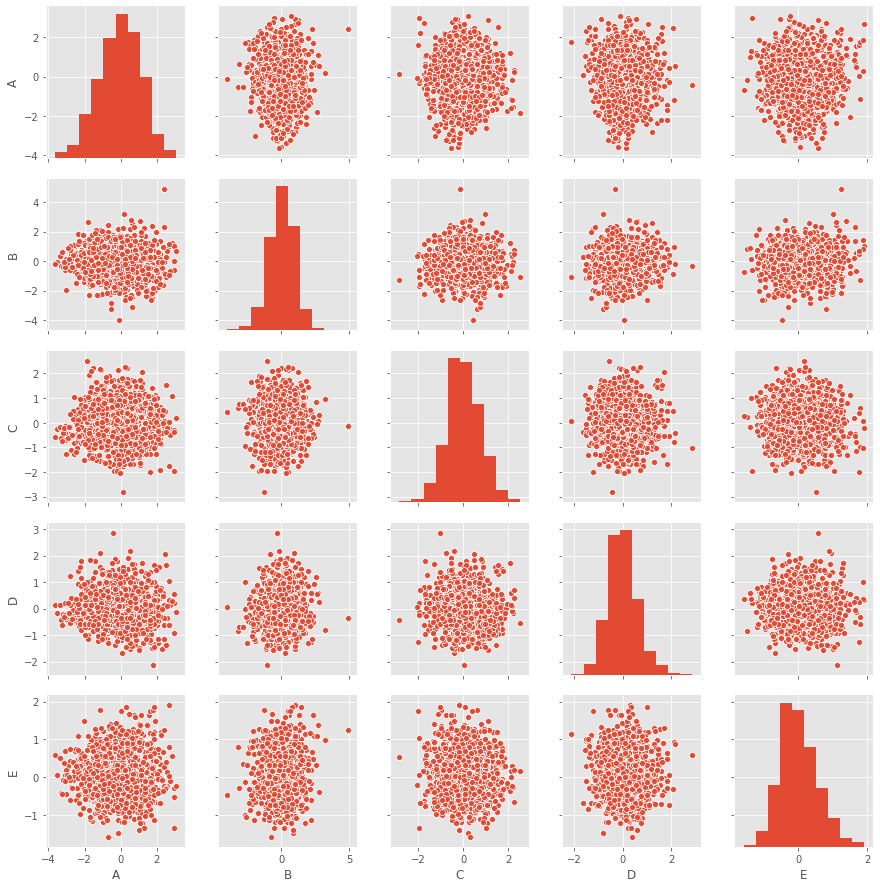

In [102]:
sns.pairplot(personality_df, kind="scatter")

### check for group clusters

#### using t-sne

In [103]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib
matplotlib.style.use('ggplot')
import scipy

In [104]:
tmp_df = personality_df.drop(['UserIdentifier'],axis=1)

In [105]:
tmp_df = tmp_df.astype(np.float32)
tmp_df = tmp_df.dropna()

In [112]:
# computing t-SNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=3, perplexity=20, n_iter=500,learning_rate=250)
tsne_results = tsne.fit_transform(tmp_df)
print ("t-SNE done! Time elapsed: {} seconds".format(time.time()-time_start))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1644 samples in 0.001s...
[t-SNE] Computed neighbors for 1644 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1644
[t-SNE] Computed conditional probabilities for sample 1644 / 1644
[t-SNE] Mean sigma: 0.414175
[t-SNE] Computed conditional probabilities in 0.036s
[t-SNE] Iteration 50: error = 81.1388016, gradient norm = 0.0681267 (50 iterations in 0.425s)
[t-SNE] Iteration 100: error = 77.6012878, gradient norm = 0.0720327 (50 iterations in 0.376s)
[t-SNE] Iteration 150: error = 76.9509735, gradient norm = 0.0653967 (50 iterations in 0.322s)
[t-SNE] Iteration 200: error = 76.9337692, gradient norm = 0.0656062 (50 iterations in 0.326s)
[t-SNE] Iteration 250: error = 76.9313660, gradient norm = 0.0636214 (50 iterations in 0.331s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.931366
[t-SNE] Iteration 300: error = 1.6209545, gradient norm = 0.0009084 (50 iterations in 0.310s)

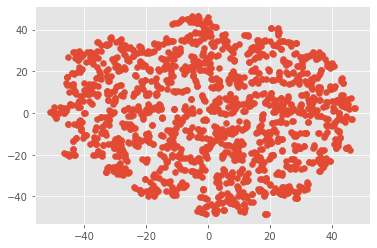

In [113]:
plt.scatter(tsne_results[:,0], tsne_results[:,1])

#### k- means

### pair plot for user data

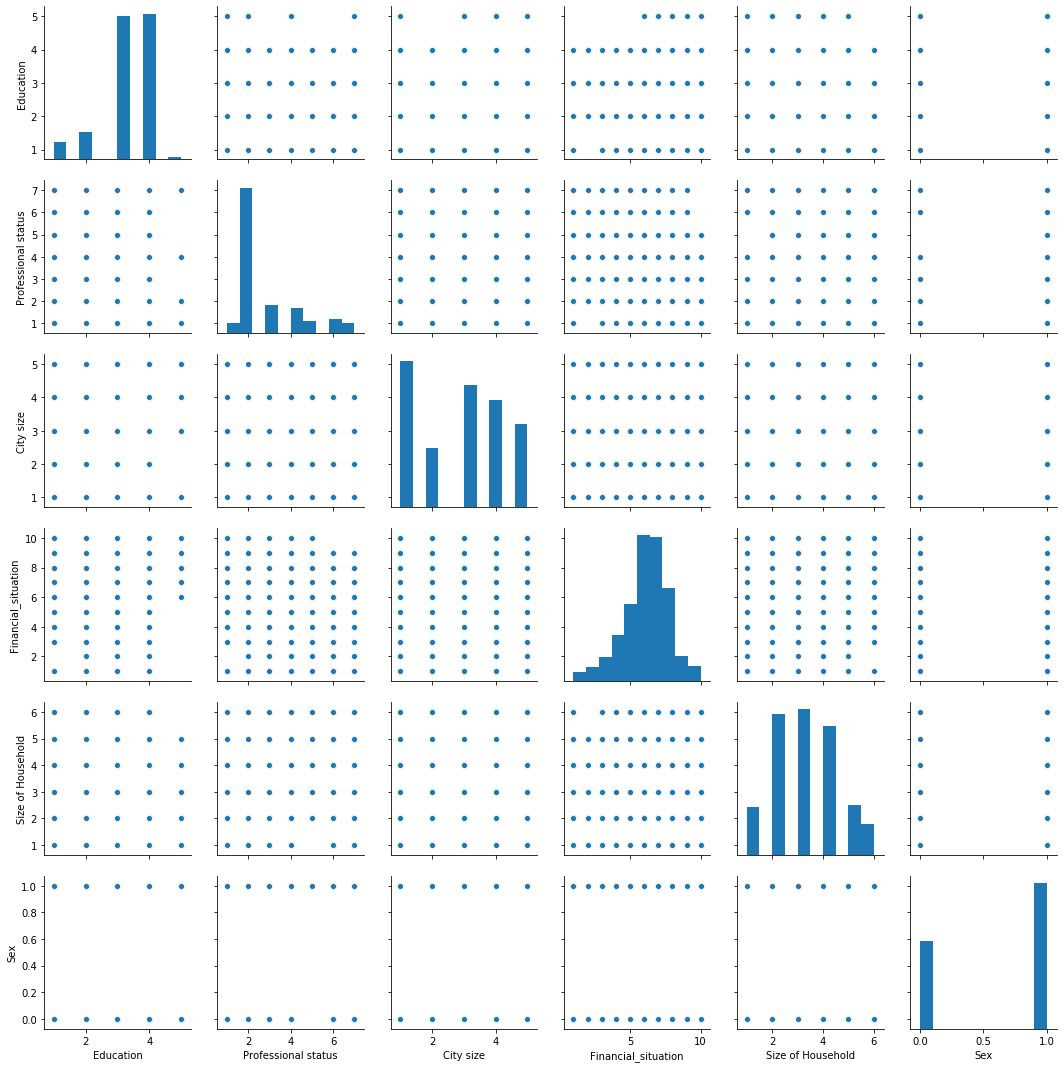

In [81]:
sns.pairplot(users_df, kind="scatter")

#### Step 1:  combine these two csv files through joining on the unique UserIdentifier column 

In [41]:
f"there are {len(users_df['UserIdentifier'].unique())} unique identifies in the users csv"

'there are 1678 unique identifies in the users csv'

In [42]:
f"there are {len(personality_df['UserIdentifier'].unique())} unique identifies in the personality csv"

'there are 1521 unique identifies in the personality csv'

Hence, since these numbers do not match, we'll merge on the user csv 

In [63]:
df = personality_df.join(users_df, lsuffix='UserIdentifier')
df = df.drop(["UserIdentifierUserIdentifier"], axis=1)

In [64]:
df.head()

,A,B,C,D,E,UserIdentifier,Education,Professional status,City size,Financial_situation,Size of Household,Browser,Version,Device,Sex,Generation
0,0.041197,-0.389188,-0.257404,0.732678,-0.769127,d2d10f362bb1d0092174a660778cbe50,3.0,4.0,2.0,6.0,2.0,Firefox,69.0,Desktop,0.0,pokolenie BB
1,-0.596461,0.620304,-0.611045,-0.256928,-0.244441,083a56a91d0d1ee4e66643849133b2b3,2.0,2.0,2.0,7.0,2.0,Chrome,70.0.3538.110,Mobile,0.0,pokolenie BB
2,-1.198166,-0.821102,0.298394,-0.031738,0.821793,fdc1004b329f2aca4c81ad59c93c1be0,4.0,1.0,4.0,5.0,6.0,Chrome,77.0.3865.90,Desktop,1.0,pokolenie X
3,-0.344910,-1.611630,0.220709,-0.323851,-0.127276,8b8a4372a0f3fd3e1a1d4c531211506e,3.0,2.0,4.0,5.0,4.0,Chrome,75.0.3770.142,Desktop,1.0,pokolenie Y
4,-0.365047,1.094319,-0.187957,-0.254589,0.554409,58d0c701bf73a5949e2ee29f387fb5a2,3.0,3.0,1.0,7.0,6.0,Chrome,78.0.3904.108,Mobile,0.0,pokolenie Z


In [77]:
# personality_df[['A', 'B', 'C', 'D', 'E']].corrwith(users_df[['Education', 
#           'Professional status',
#           'City size',
#           'Financial_situation',
#           'Size of Household',
#          'Sex']])

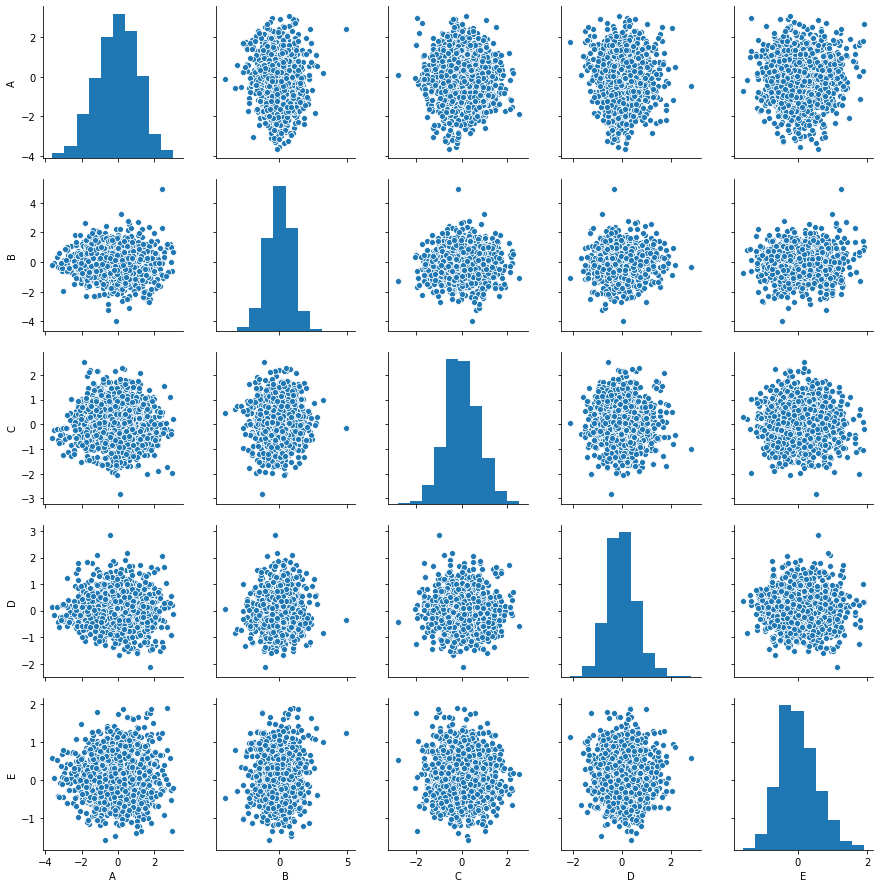

### 4. Check correlation through scatter plots

In [30]:
df = users_df[['Income','Loan_amount','Investment','age','work_exp']]

sns.pairplot(df, kind="scatter")
plt.show()

KeyError: "None of [Index(['Income', 'Loan_amount', 'Investment', 'age', 'work_exp'], dtype='object')] are in the [columns]"